# <center> ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

## Постановка задачи
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.
Наша задача исследовать данные и сделать выводы по полученным результатам. Подкрепить свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверить, являются ли выводы статистически значимыми.

В процессе анализа мы должны ответить на ключевые вопросы HR-агентства:

- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Какие факторы влияют на зарплату у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в различных компаниях?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрировать использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
-- для одной выборки;
-- для двух выборок;
-- для нескольких выборок;
- тест для категориальных признаков.

Источник датасета: ["“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)


## Загрузка данных

In [130]:
# загружаем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from statsmodels.stats.contingency_tables import mcnemar

import matplotlib.pyplot as plt
import seaborn as sns

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2")


In [131]:
#загружаем датасет
data = pd.read_csv('ds_salaries.csv')
data.head()

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [132]:
# задаём уровень значимости
alpha = 0.05 
print("Уровень значимости alpha = {:.2f}".format(alpha))

Уровень значимости alpha = 0.05


## Описательный анализ данных

In [133]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          607 non-null    int64 
 1   work_year           607 non-null    int64 
 2   experience_level    607 non-null    object
 3   employment_type     607 non-null    object
 4   job_title           607 non-null    object
 5   salary              607 non-null    int64 
 6   salary_currency     607 non-null    object
 7   salary_in_usd       607 non-null    int64 
 8   employee_residence  607 non-null    object
 9   remote_ratio        607 non-null    int64 
 10  company_location    607 non-null    object
 11  company_size        607 non-null    object
dtypes: int64(5), object(7)
memory usage: 57.0+ KB


В датасете 607 записей (без пропущенных значений).

Проверим данные на наличие полных дубликатов:

In [134]:
print('Количество дубликатов: {}'.format(data[data.duplicated()].shape[0]))


Количество дубликатов: 0


Проверим данные на наличие неинформативных признаков

Признак "Unnamed: 0" повторяет индекс, поэтому его можно убрать. Признак "salary" отображает величину зарплаты в разных валютах, и, можно сказать, повторяет признак "salary_in_usd". Поэтому оставим признак "salary_in_usd" отображающий величину зарплаты в USD, а признаки "salary" и "salary_currency" удалим.

In [135]:
data = data.drop(['Unnamed: 0','salary','salary_currency'],axis=1)


Общее распределение зарплат в USD в сфере Data Science за 2020–2022

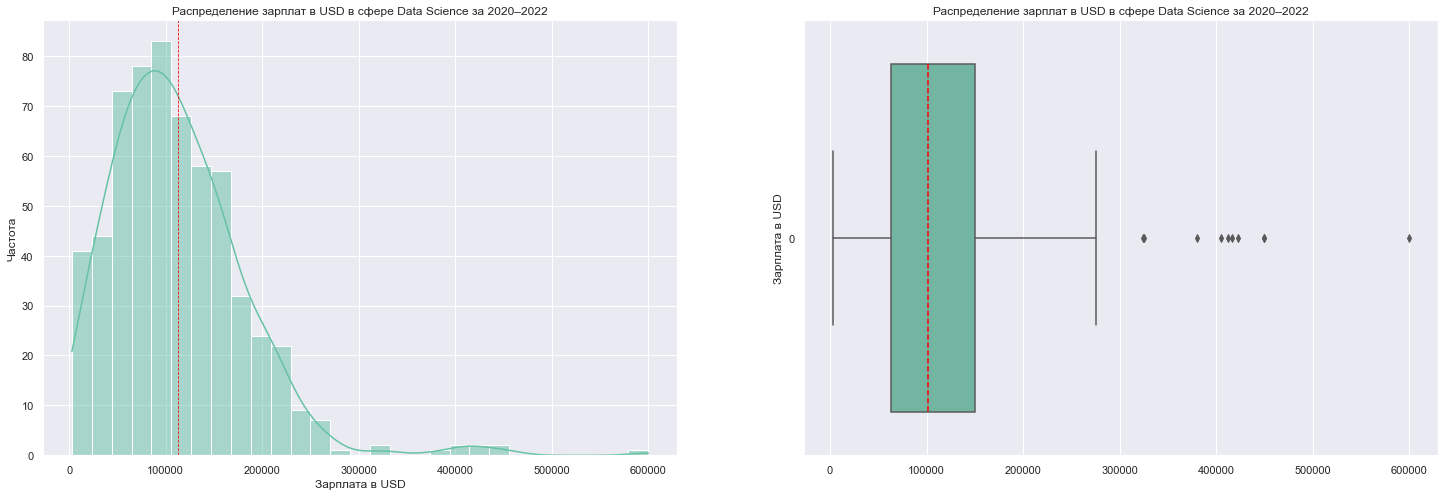

In [136]:
fig, axes = plt.subplots(1, 2, figsize=(25, 8))

sns.histplot(data['salary_in_usd'], kde=True, ax=axes[0])
axes[0].set(xlabel='Зарплата в USD', ylabel='Частота')
axes[0].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')
axes[0].axvline(data['salary_in_usd'].mean(), color='red', linestyle='--', linewidth=0.8)

sns.boxplot(data['salary_in_usd'], ax=axes[1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[1].set(ylabel='Зарплата в USD')
axes[1].set_title('Распределение зарплат в USD в сфере Data Science за 2020–2022')

plt.show()

In [137]:
data_agg = data['salary_in_usd'].describe().round(2).to_frame()
data_agg.columns = ['Зарплата в USD']
data_agg

,Зарплата в USD
count,607.00
mean,112297.87
std,70957.26
min,2859.00
25%,62726.00
50%,101570.00
75%,150000.00
max,600000.00


Распеределение зарплат в USD отлично от нормального, имеются выбросы.

### Зарплата в USD в зависимости от года

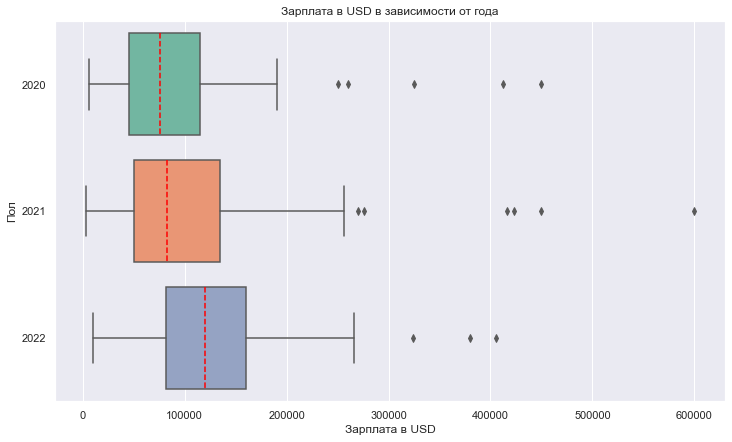

In [138]:
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Пол')
plt.title('Зарплата в USD в зависимости от года')
plt.show()

In [139]:
data_agg = data.groupby('work_year')['salary_in_usd'].describe()
print('Зарплата в USD в зависимости от года')
data_agg

Зарплата в USD в зависимости от года


,count,mean,std,min,25%,50%,75%,max
work_year,,,,,,,,
2020,72.0,95813.000000,82831.799222,5707.0,45724.5,75544.0,115526.0,450000.0
2021,217.0,99853.792627,80225.106319,2859.0,50000.0,82528.0,135000.0,600000.0
2022,318.0,124522.006289,58183.647585,10000.0,81666.0,120000.0,160000.0,405000.0


Из полученных данных видно, что медианная зарплата с каждым годом повышается. Особенно видно различие между 2021 и 2022 годом. Так же видно, что количество вакансий с каждым годом существенно увеличивается. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистические тесты.

### Факторы влияющие на зарплату у специалистов Data Scientist

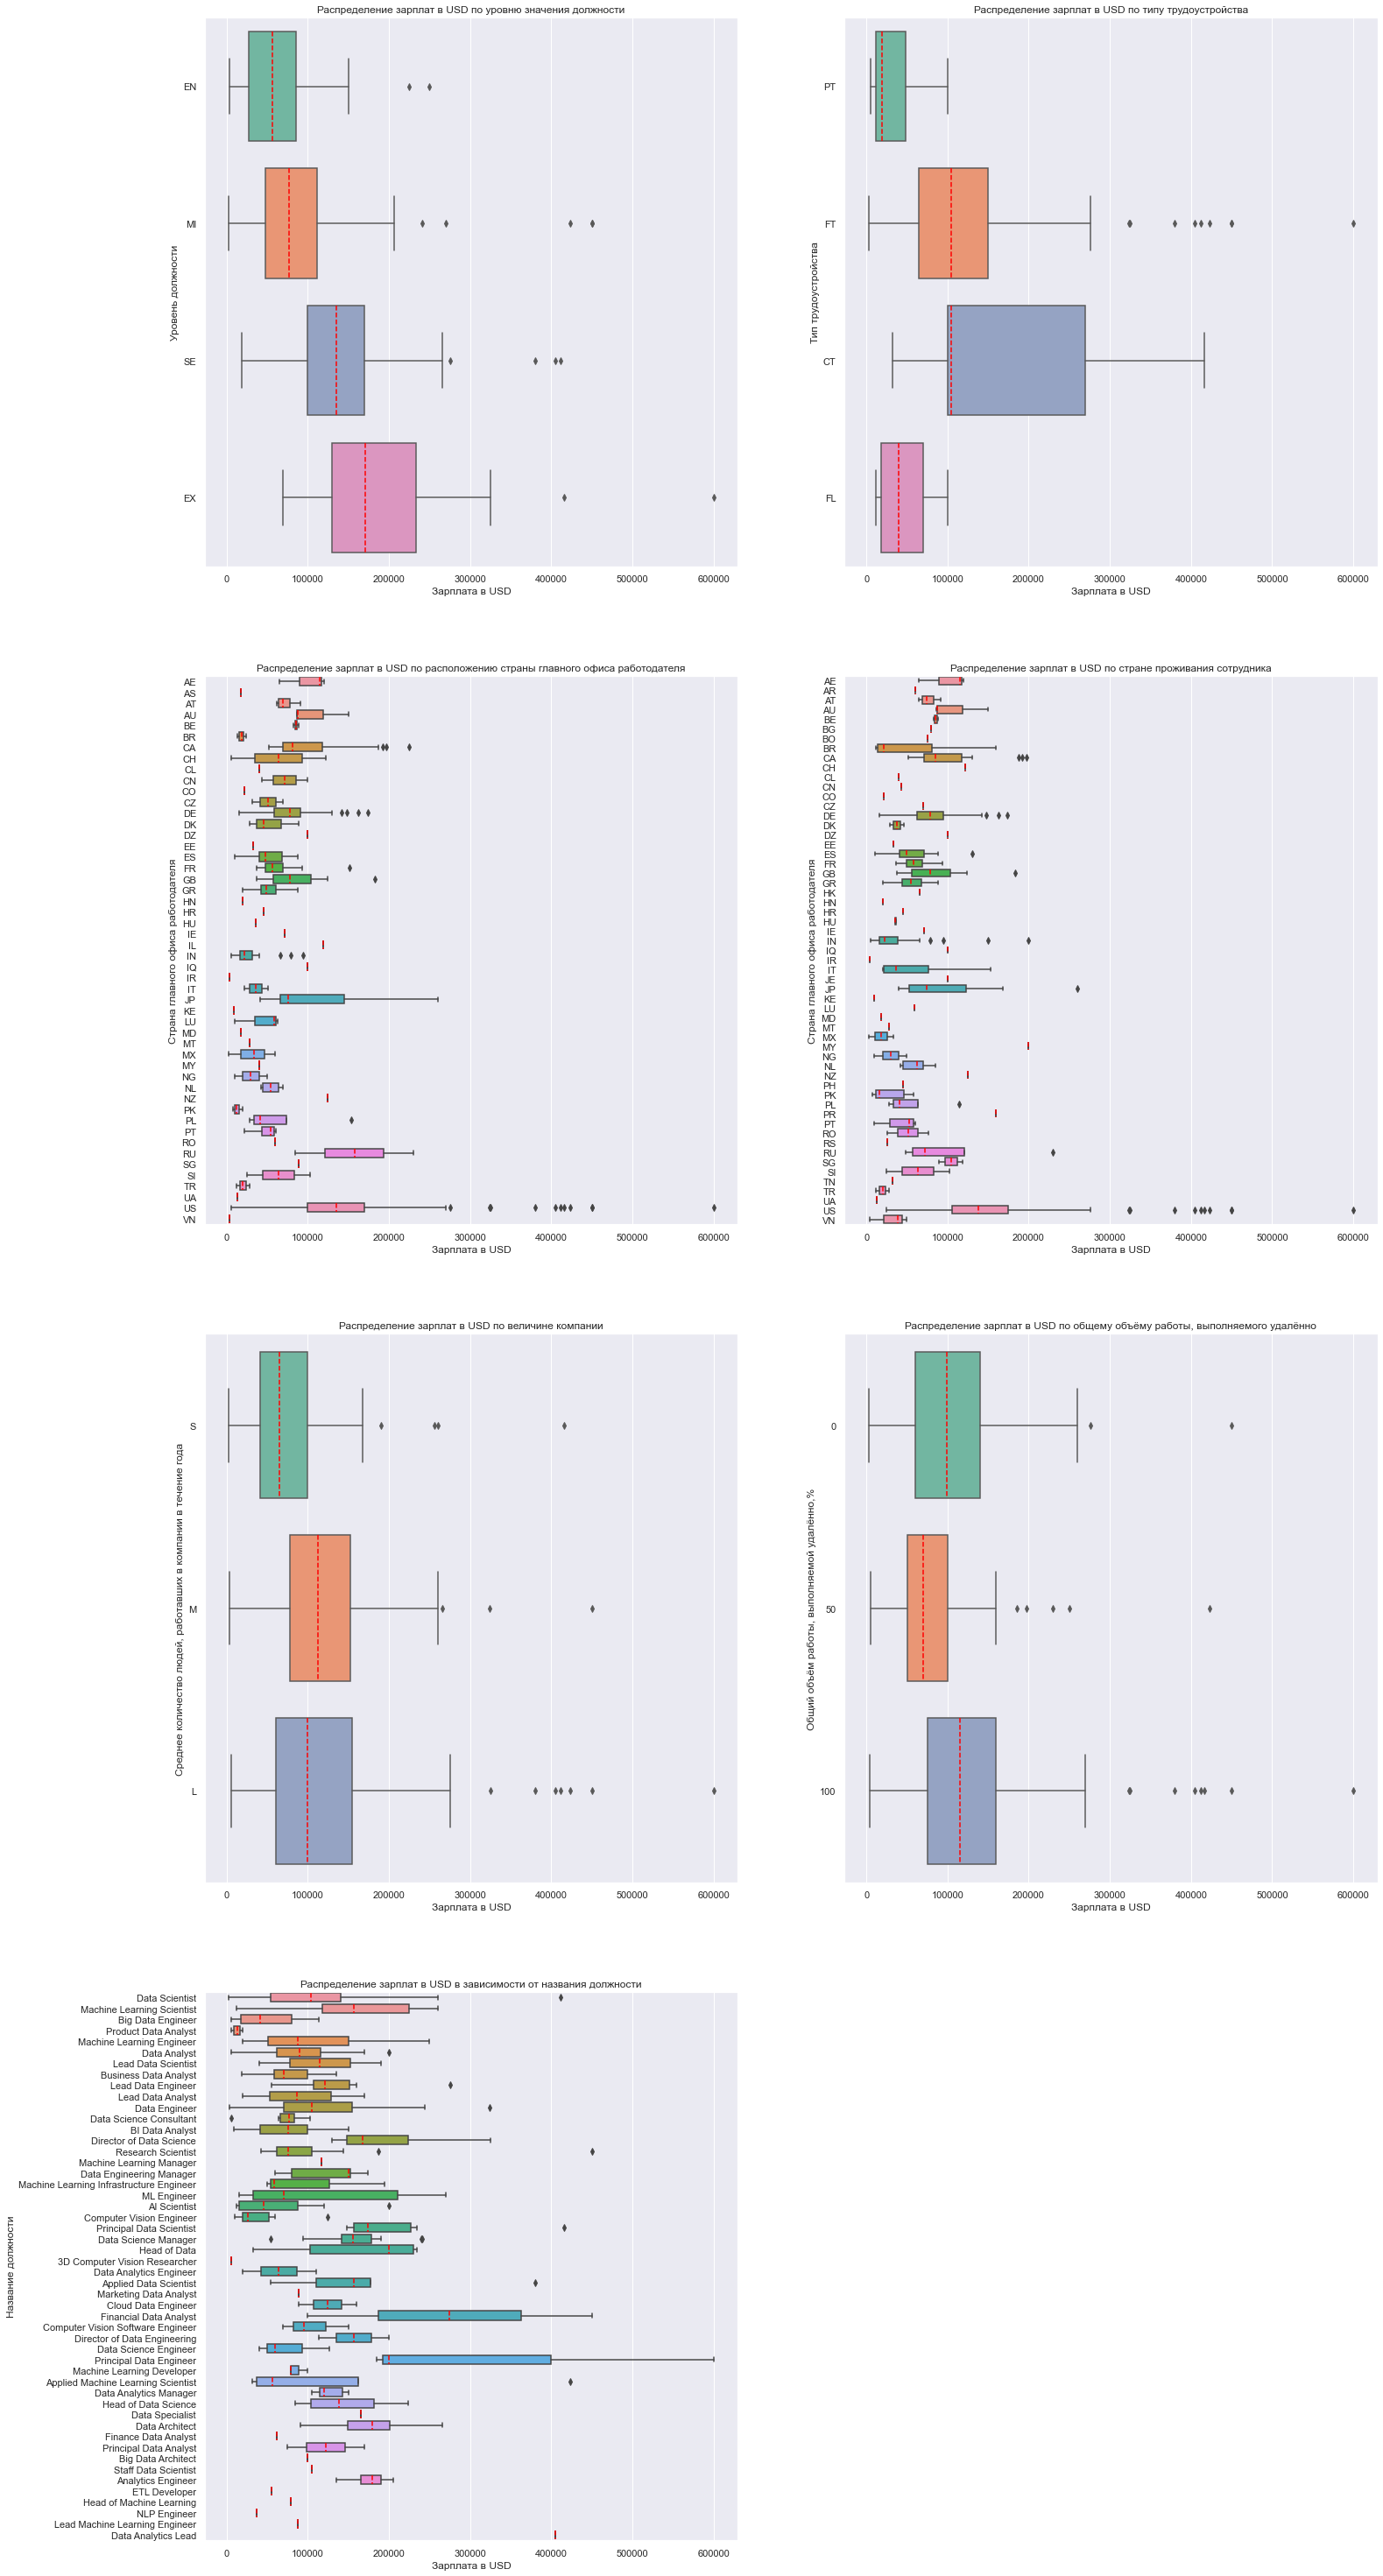

In [140]:
fig, axes = plt.subplots(4, 2, figsize=(24, 53))

sns.boxplot(data, x='salary_in_usd', y='experience_level',  ax=axes[0, 0], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['EN', 'MI', 'SE', 'EX'])
axes[0, 0].set(xlabel='Зарплата в USD', ylabel='Уровень должности')
axes[0, 0].set_title('Распределение зарплат в USD по уровню значения должности')


sns.boxplot(data, x='salary_in_usd', y='employment_type', ax=axes[0, 1], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['PT', 'FT', 'CT', 'FL'])
axes[0, 1].set(xlabel='Зарплата в USD', ylabel='Тип трудоустройства')
axes[0, 1].set_title('Распределение зарплат в USD по типу трудоустройства')


sns.boxplot(data, x='salary_in_usd', y='company_location', ax=axes[1, 0], orient='h', medianprops={"color": "red", "linestyle": '--'}, order=sorted(data['company_location'].unique()))
axes[1, 0].set(xlabel='Зарплата в USD', ylabel='Страна главного офиса работодателя')
axes[1, 0].set_title('Распределение зарплат в USD по расположению страны главного офиса работодателя')

sns.boxplot(data, x='salary_in_usd', y='employee_residence', ax=axes[1, 1], orient='h', medianprops={"color": "red", "linestyle": '--'}, order=sorted(data['employee_residence'].unique()))
axes[1, 1].set(xlabel='Зарплата в USD', ylabel='Страна главного офиса работодателя')
axes[1, 1].set_title('Распределение зарплат в USD по стране проживания сотрудника')

sns.boxplot(data, x='salary_in_usd', y='company_size', ax=axes[2, 0], orient='h', medianprops={"color": "red", "linestyle": '--'},order=['S', 'M', 'L'])
axes[2, 0].set(xlabel='Зарплата в USD', ylabel='Среднее количество людей, работавших в компании в течение года')
axes[2, 0].set_title('Распределение зарплат в USD по величине компании')

sns.boxplot(data, x='salary_in_usd', y='remote_ratio', ax=axes[2, 1], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[2, 1].set(xlabel='Зарплата в USD', ylabel='Общий объём работы, выполняемой удалённо,%')
axes[2, 1].set_title('Распределение зарплат в USD по общему объёму работы, выполняемого удалённо')

sns.boxplot(data, x='salary_in_usd', y='job_title', ax=axes[3, 0], orient='h', medianprops={"color": "red", "linestyle": '--'})
axes[3, 0].set(xlabel='Зарплата в USD', ylabel='Название должности')
axes[3, 0].set_title('Распределение зарплат в USD в зависимости от названия должности')



fig.delaxes(axes[3,1])


plt.show()


In [141]:
custom_order = ['EN', 'MI', 'SE', 'EX']

# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('experience_level')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от уровня должности')
data_agg

Зарплата в USD  зависимости от уровня должности


,count,mean,std,min,25%,50%,75%,max
experience_level,,,,,,,,
EN,88.0,61643.318182,44395.541126,4000.0,27505.0,56500.0,85425.75,250000.0
MI,213.0,87996.056338,63901.057478,2859.0,48000.0,76940.0,112000.00,450000.0
SE,280.0,138617.292857,57691.978337,18907.0,100000.0,135500.0,170000.00,412000.0
EX,26.0,199392.038462,117071.255697,69741.0,130006.5,171437.5,233750.00,600000.0


Распределение зарплат относительно уровня должности различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

In [142]:
custom_order = ['PT', 'FT', 'CT', 'FL']

# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('employment_type')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от типа трудоустройства')
data_agg

Зарплата в USD  зависимости от типа трудоустройства


,count,mean,std,min,25%,50%,75%,max
employment_type,,,,,,,,
PT,10.0,33070.500000,31472.907966,5409.0,12000.00,18817.5,48370.0,100000.0
FT,588.0,113468.073129,69476.470098,2859.0,64962.25,104196.5,150000.0,600000.0
CT,5.0,184575.000000,156250.889997,31875.0,100000.00,105000.0,270000.0,416000.0
FL,4.0,48000.000000,40529.824410,12000.0,18000.00,40000.0,70000.0,100000.0


Распределение зарплат относительно типа трудоустройства различны. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

In [143]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('company_location')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от страны главного офиса работодателя')
data_agg

Зарплата в USD в зависимости от страны главного офиса работодателя


,count,mean,std,min,25%,50%,75%,max
company_location,,,,,,,,
AE,3.0,100000.000000,30413.812651,65000.0,90000.00,115000.0,117500.00,120000.0
AS,1.0,18053.000000,NaN,18053.0,18053.00,18053.0,18053.00,18053.0
AT,4.0,72920.750000,13332.777114,61467.0,64003.50,69489.5,78406.75,91237.0
AU,3.0,108042.666667,36337.909768,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.000000,4179.001077,82744.0,84221.50,85699.0,87176.50,88654.0
BR,3.0,18602.666667,5555.755064,12901.0,15904.00,18907.0,21453.50,24000.0
CA,30.0,99823.733333,46329.101553,52000.0,69730.00,81895.5,117916.25,225000.0
CH,2.0,64114.000000,82352.484164,5882.0,34998.00,64114.0,93230.00,122346.0
CL,1.0,40038.000000,NaN,40038.0,40038.00,40038.0,40038.00,40038.0


Распределение зарплат относительно стран различно.

In [144]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('employee_residence')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от страны проживания сотрудника')
data_agg

Зарплата в USD в зависимости от страны проживания сотрудника


,count,mean,std,min,25%,50%,75%,max
employee_residence,,,,,,,,
AE,3.0,100000.000000,30413.812651,65000.0,90000.00,115000.0,117500.00,120000.0
AR,1.0,60000.000000,NaN,60000.0,60000.00,60000.0,60000.00,60000.0
AT,3.0,76738.666667,13386.018539,64849.0,69489.50,74130.0,82683.50,91237.0
AU,3.0,108042.666667,36337.909768,86703.0,87064.00,87425.0,118712.50,150000.0
BE,2.0,85699.000000,4179.001077,82744.0,84221.50,85699.0,87176.50,88654.0
BG,1.0,80000.000000,NaN,80000.0,80000.00,80000.0,80000.00,80000.0
BO,1.0,75000.000000,NaN,75000.0,75000.00,75000.0,75000.00,75000.0
BR,6.0,54634.666667,61537.353923,12000.0,14402.50,21453.5,81000.00,160000.0
CA,29.0,97085.310345,39767.443731,52000.0,70912.00,85000.0,117104.00,196979.0


Распределение зарплат относительно стран проживания различно.

In [145]:
custom_order = ['S', 'M', 'L']

# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('company_size')['salary_in_usd'].describe()
data_agg = data_agg.reindex(custom_order)

# Выводим результат
print('Зарплата в USD  зависимости от величины компании')
data_agg

Зарплата в USD  зависимости от величины компании


,count,mean,std,min,25%,50%,75%,max
company_size,,,,,,,,
S,83.0,77632.674699,63461.706497,2859.0,41943.00,65000.0,100000.0,416000.0
M,326.0,116905.466258,59287.694614,4000.0,78131.50,113188.0,152875.0,450000.0
L,198.0,119242.994949,86156.740692,5882.0,61041.75,100000.0,154600.0,600000.0


Распределение зарплат относительно величины космпании различно. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

In [146]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('remote_ratio')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от общего объёма работы, выполняемого удалённо в %')
data_agg

Зарплата в USD в зависимости от общего объёма работы, выполняемого удалённо в %


,count,mean,std,min,25%,50%,75%,max
remote_ratio,,,,,,,,
0,127.0,106354.622047,67724.540800,2859.0,60000.0,99000.0,140400.0,450000.0
50,99.0,80823.030303,57353.093614,5409.0,50355.0,69999.0,99851.5,423000.0
100,381.0,122457.454068,72710.843718,4000.0,75774.0,115000.0,160000.0,600000.0


Распределение зарплат относительно процента выполняемой удаленно работы различно. Чтобы определить, являются ли эти различия статистически значимыми, в следующем разделе мы проведём статистическое тестирование.

In [147]:
# Группируем данные и выводим их в произвольном порядке
data_agg = data.groupby('job_title')['salary_in_usd'].describe()

# Выводим результат
print('Зарплата в USD в зависимости от названия должности')
data_agg

Зарплата в USD в зависимости от названия должности


,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
3D Computer Vision Researcher,1.0,5409.000000,NaN,5409.0,5409.00,5409.0,5409.00,5409.0
AI Scientist,7.0,66135.571429,70152.164338,12000.0,15026.50,45896.0,87500.00,200000.0
Analytics Engineer,4.0,175000.000000,29508.077990,135000.0,165000.00,179850.0,189850.00,205300.0
Applied Data Scientist,5.0,175655.000000,123647.186470,54238.0,110037.00,157000.0,177000.00,380000.0
Applied Machine Learning Scientist,4.0,142068.750000,188246.696933,31875.0,36768.75,56700.0,162000.00,423000.0
BI Data Analyst,6.0,74755.166667,50989.558548,9272.0,40944.25,76500.0,99500.00,150000.0
Big Data Architect,1.0,99703.000000,NaN,99703.0,99703.00,99703.0,99703.00,99703.0
Big Data Engineer,8.0,51974.000000,42954.761263,5882.0,17557.00,41305.5,79756.00,114047.0
Business Data Analyst,5.0,76691.200000,43814.851149,18442.0,59102.00,70912.0,100000.00,135000.0


Распределение запрлат относительно занимаемой должности различно.

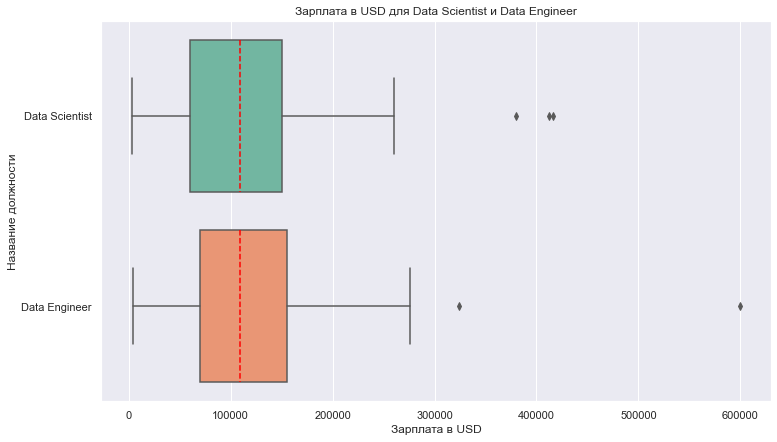

In [148]:

# все должности, в названии которых есть словосочетание Data Scientist приведем к общему названию "Data Scientist" для упрощения построения графика. То же самое сделаем для "Data Engineer". Чувствительностью к регистру здесь можно пренебречь.
# переименовывем значения в признаке 'job_title'
mask_rename= data['job_title'].apply(lambda x:"Data Scientist" if "Data Scientist" in x else ("Data Engineer" if "Data Engineer" in x else x))

# заменяем столбец в скопированном датасете
data_DS_and_Eng = data.copy()
data_DS_and_Eng['job_title']=mask_rename
data_DS_and_Eng_only=data_DS_and_Eng[data_DS_and_Eng['job_title'].str.contains('Data Scientist|Data Engineer')]
# строим график для Data Scientist и Data Engineer из нового датасета с обновленными названиями
plt.figure(figsize=(12, 7))
ax = sns.boxplot(data_DS_and_Eng_only, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set(xlabel='Зарплата в USD', ylabel='Название должности')
plt.title('Зарплата в USD для Data Scientist и Data Engineer')
plt.show()


In [149]:
data_DS_and_Eng_only.groupby('job_title')['salary_in_usd'].describe()

,count,mean,std,min,25%,50%,75%,max
job_title,,,,,,,,
Data Engineer,158.0,115808.512658,70474.677434,4000.0,69805.75,108912.0,154900.0,600000.0
Data Scientist,159.0,115134.603774,71391.525030,2859.0,59733.50,109000.0,150000.0,416000.0


Судя по данным зарплаты для Data Engineer и Data Scientist практически равны. Чтобы определить, так ли это, в следующем разделе мы проведём статистические тесты.

### Связь между наличием должностей Data Scientist и Data Engineer и размером компании

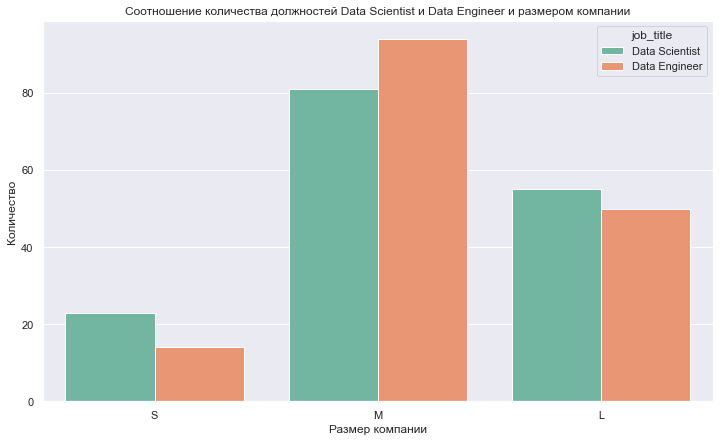

In [150]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data=data_DS_and_Eng[data_DS_and_Eng['job_title'].str.contains('Data Scientist|Data Engineer')], x='company_size', hue='job_title',order=['S','M','L'])
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение количества должностей Data Scientist и Data Engineer и размером компании')
plt.show()

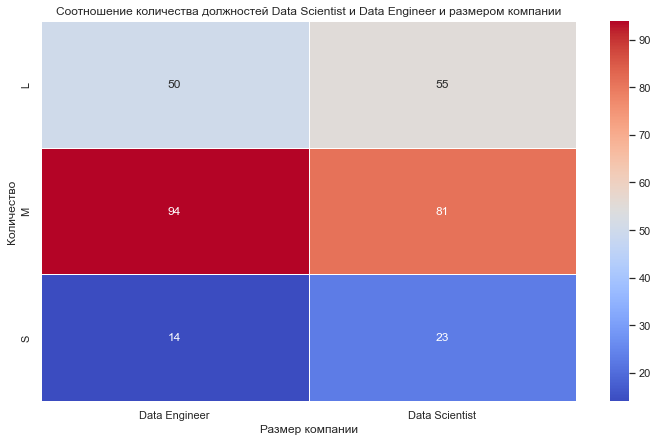

In [151]:
plt.figure(figsize=(12, 7))
cross_tab = pd.crosstab(index=data_DS_and_Eng_only['company_size'], columns=data_DS_and_Eng['job_title'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение количества должностей Data Scientist и Data Engineer и размером компании')
plt.show()

Судя по полученным данным связь для должностей Data Scientist и Data Engineer и размером компании сущетсвует. В маленьких компаниях такие должности встречаются редко. Больше всего их в средних компаниях. В больших компаниях их заметно меньше, чем в средних. Чтобы определить, так ли это, в следующем разделе мы проведём статистические тесты.

## Статистический анализ данных




In [152]:
# функция для принятия решения о нормальности
def decision_normality(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Распределение отлично от нормального'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. Распределение является нормальным'.format(alpha))


# функция для принятия решения об отклонении нулевой гипотезы
def decision_hypothesis(p):
    print('p-value = {:.3f}'.format(p))
    if p <= alpha:
        print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.'.format(alpha))
    else:
        print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))
      

### Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

**Сначала сравним 2020 и 2021 год**

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза* ($H_0$): размер зарплаты за 2020 ($μ_1$) статистически больше либо равен размеру зарплаты за 2021($μ_2$).

$$ H_0 : μ_1 => μ_2$$

*Альтернативная гипотеза* ($H_1$):  размер зарплаты за 2020 ($μ_1$) статистически меньше размера зарплаты за 2021($μ_2$)

$$ H_1 : μ_1 < μ_2$$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Напомним гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [153]:
# значения страховых выплат
salary_2020 = data.loc[data['work_year']==2020, 'salary_in_usd']
salary_2021 = data.loc[data['work_year']==2021, 'salary_in_usd']
salary_2022 = data.loc[data['work_year']==2022, 'salary_in_usd']

# проводим тест Шапиро-Уилка
print('2020:')
result = stats.shapiro(salary_2020)
decision_normality(result[1])

print('2021:')
result = stats.shapiro(salary_2021)
decision_normality(result[1])

2020:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального
2021:
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Распределение отлично от нормального


**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «Зарплата в долларах США»? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Нет.

Чтобы проверить нашу гипотезу, можно использовать U-критерий Манна — Уитни для сравнения распределений на основе рангов.

**Проведём тест**

In [154]:

_, p = stats.mannwhitneyu(salary_2020, salary_2021, alternative='less')
decision_hypothesis(p)


p-value = 0.232
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.
p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


In [157]:
# проведем такой же тест для 2021 года и 2022 года
_, p = stats.mannwhitneyu(salary_2021, salary_2022, alternative='less')
decision_hypothesis(p)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**

С 2020 по 2021 размер зарплат у специалистов Data Scientist не вырос. Но с 2021 по 2022 размер зарплат увеличился.

### Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

**Сформулируем нулевую и альтернативные гипотезы**

*Нулевая гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании нет взаимосвязи (признаки независимы).

*Альтернативная гипотеза*: между наличием должностей Data Scientist и Data Engineer и размером компании есть взаимосвязь(признаки зависимы).

**Выберем подходящий статистический тест**

Для выбора нужного теста воспользуемся алгоритмом выбора теста. Для этого ответим на следующие вопросы:
* Какой тип у признака «company_size»(размер компании)? — Категориальный.
* Сколько сравниваемых групп? — Две.
* Проверяется независимость групп? — Да.

Для проверки нашей гипотезы можно использовать критерий ${\chi}^2$ (хи-квадрат).

**Проведём тест**

In [155]:
table = pd.crosstab(data_DS_and_Eng_only['company_size'], data_DS_and_Eng_only['job_title'])

display(table)
# проводим тест
_, p, _, _ = stats.chi2_contingency(table)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

# p-value = 0.373
# p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.

job_title,Data Engineer,Data Scientist
company_size,,
L,50,55
M,94,81
S,14,23


p-value = 0.184
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


In [156]:
salary_2020 = data.loc[data['work_year']=='2020', 'salary_in_usd']
salary_2020

Series([], Name: salary_in_usd, dtype: int64)